In [15]:
!pip install patchify

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.layers import Rescaling


def get_unet_model(img_height, img_width, img_channels, n_classes):
    # input layer shape is equal to patch image size
    inputs = Input(shape=(img_height, img_width, img_channels))

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(rescale)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(c9)

    return Model(inputs=[inputs], outputs=[outputs])


In [17]:
import datetime
import math
import os
from enum import Enum

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.models import Model, load_model
from keras.utils import to_categorical
from patchify import patchify
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, UpSampling2D, RandomFlip
from keras.layers import Rescaling
from tqdm import tqdm


# =======================================================
# image preprocessing

def load_images_and_patchify(directory_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for file_number, filepath in tqdm(enumerate(os.listdir(directory_path))):
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = rf"{directory_path}/{filepath}"

            # Reads image as BGR
            image = cv2.imread(img_path)

            # convert image to RBG
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))

            # Extract patches from each image, step=patch_size means no overlap
            patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            # iterate over vertical patch axis
            for j in range(patch_img.shape[0]):
                # iterate over horizontal patch axis
                for k in range(patch_img.shape[1]):
                    # patches are located like a grid. use (j, k) indices to extract single patched image
                    single_patch_img = patch_img[j, k]

                    # Drop extra dimension from patchify
                    instances.append(np.squeeze(single_patch_img))

    return instances


def reshape_images(instances):
    """
    :param instances: list of images
    :return: reshaped images
    """
    for j in range(len(instances)):
        instances[j] = instances[j].reshape(-1, 1)
    return instances


def get_minimum_image_size(instances):
    """
    :param instances: list of images
    :return: min and max dimensions out of all images
    """

    # initialize minimum values to infinity
    min_x = math.inf
    min_y = math.inf

    # loop through each instance
    for image in instances:
        # check min x (rows)
        min_x = image.shape[0] if image.shape[0] < min_x else min_x

        # check min y (columns)
        min_y = image.shape[1] if image.shape[1] < min_y else min_y

    return min_x, min_y


def display_images(instances, rows=2, titles=None):
    """
    :param instances:  list of images
    :param rows: number of rows in subplot
    :param titles: subplot titles
    :return:
    """
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    # iterate through images and display subplots
    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    # show the figure
    plt.show()


# =====================================================
# prepare training data input images

def get_training_data(root_directory):
    # initialise lists
    image_dataset, mask_dataset = [], []

    # define image patch size
    patch_size = 128

    # walk through root directory
    for path, directories, files in os.walk(root_directory):
        for subdirectory in directories:

            # extract training input images and patchify
            if subdirectory == "images":
                image_dataset.extend(
                    load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size))

            # extract training label masks and patchify
            elif subdirectory == "masks":
                mask_dataset.extend(
                    load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size))

    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset)


def create_binary_segmentation_problem(image_dataset, mask_dataset):
    # change problem to binary segmentation problem
    x_reduced, y_reduced = [], []

    # iterate over masks
    for j, mask in tqdm(enumerate(mask_dataset)):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create binary image (zeros)
        binary_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        # iterate over each pixel in mask
        for row in range(_img_height):
            for col in range(_img_width):
                # get image channel across axis=3
                rgb = mask[row, col, :]

                # building hex: #3C1098 = RGB(60, 16, 152) or BGR(152, 16, 60)
                binary_image[row, col] = 1 if rgb[0] == 60 and rgb[1] == 16 and rgb[2] == 152 else 0

        # only keep images with a high percentage of building coverage
        if np.count_nonzero(binary_image == 1) > 0.15 * binary_image.size:
            x_reduced.append(image_dataset[j])
            y_reduced.append(binary_image)

    # return binary image dataset
    return np.array(x_reduced), np.array(y_reduced)


# mask color codes
class MaskColorMap(Enum):
    Unlabelled = (155, 155, 155)
    Building = (60, 16, 152)
    Land = (132, 41, 246)
    Road = (110, 193, 228)
    Vegetation = (254, 221, 58)
    Water = (226, 169, 41)


def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset
    :param num_classes: number of classes
    :return:
    """
    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(x=integer_encoded_labels, num_classes=num_classes)


# =====================================================
# output directories

# datetime for filename saving
dt_now = str(datetime.datetime.now()).replace(".", "_").replace(":", "_")
model_img_save_path = f"{os.getcwd()}/models/final_aerial_segmentation_{dt_now}.png"
model_save_path = f"{os.getcwd()}/models/final_aerial_segmentation_{dt_now}.keras"
model_checkpoint_filepath = os.getcwd() + "/models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
csv_logger = rf"{os.getcwd()}/logs/aerial_segmentation_log_{dt_now}.csv"

In [18]:
# =======================================================
# training metrics

import tensorflow as tf
import numpy as np

tf.config.run_functions_eagerly(True)


def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice


# Mean Intersection-Over-Union: iou = true_positives / (true_positives + false_positives + false_negatives)
def iou_coefficient(y_true, y_pred):
  """
  Calculates the IoU coefficient between two image tensors.

  Args:
    y_true: The ground truth image tensor.
    y_pred: The predicted image tensor.

  Returns:
    The IoU coefficient.
  """

  # Calculate the intersection area.
  intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))

  # Calculate the union area.
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

  # Calculate the IoU coefficient.
  iou = intersection / union

  return iou


# jaccard similarity: the size of the intersection divided by the size of the union of two sets
# def jaccard_index(y_true, y_pred):
#   """
#   Calculates the Jaccard index between two tensors.

#   Args:
#     y_true: A tensor of ground truth values.
#     y_pred: A tensor of predicted values.

#   Returns:
#     A tensor containing the Jaccard index between the two tensors.
#   """

#   intersection = tf.reduce_sum(y_true * y_pred)
#   union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
#   return intersection / union

9it [00:00, 13.50it/s]
9it [00:00, 17.02it/s]
9it [00:00, 15.92it/s]
9it [00:00, 20.10it/s]
9it [00:00, 137.51it/s]
9it [00:00, 200.03it/s]
9it [00:00, 44.27it/s]
9it [00:00, 52.34it/s]
9it [00:00, 84.16it/s]
9it [00:00, 103.47it/s]
9it [00:00, 95.40it/s]
9it [00:00, 102.01it/s]
9it [00:00, 66.84it/s]
9it [00:00, 82.12it/s]
9it [00:00, 48.57it/s]
9it [00:00, 85.28it/s]


number of patched image training data: 5535


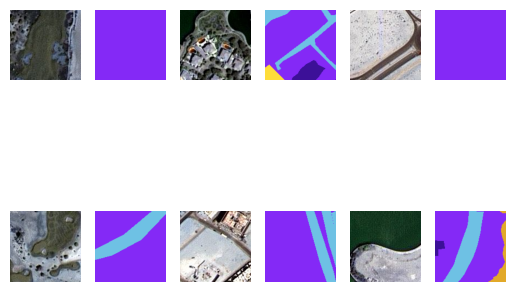

100%|██████████| 5535/5535 [00:24<00:00, 228.20it/s]


In [19]:
# =====================================================
# get training data

# number of classes in segmentation dataset
n_classes = 6

# dataset directory
data_dir = r"/kaggle/input/semantic-segmentation-of-aerial-imagery/"

# create (X, Y) training data
X, Y = get_training_data(root_directory=data_dir)

# extract X_train shape parameters
m, img_height, img_width, img_channels = X.shape
print('number of patched image training data:', m)

# display images from both training and test sets
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
display_images(sample_images, rows=2)

# convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)

# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [20]:
from keras.optimizers import Adam




# # =====================================================
# # define U-Net model architecture

# def build_unet(img_shape):
#     # input layer shape is equal to patch image size
#     inputs = Input(shape=img_shape)

#     # rescale images from (0, 255) to (0, 1)

    
#     rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)

#     augment1 = RandomFlip(mode = "horizontal_and_vertical")(rescale)

    
#     previous_block_activation = augment1  # Set aside residual

#     contraction = {}
#     # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
#     for f in [64, 128, 256, 512]:
#         x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
#             previous_block_activation)
# #         x = Dropout(0.1)(x)
#         x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
#         contraction[f'conv{f}'] = x
#         x = MaxPooling2D((2, 2))(x)
#         previous_block_activation = x
        
    
#     previous_block_activation = Conv2D(1, (3,3), activation="relu", kernel_initializer="he_normal", padding = "same")(previous_block_activation)
#     previous_block_activation = Conv2D(1, (3,3), activation="relu", kernel_initializer="he_normal", padding = "same")(previous_block_activation)
# #     c5 = Conv2D(1, (3,3), activation="relu", kernel_initializer="he_normal", padding = "same")(c5)
#     previous_block_activation = Conv2D(512, (3,3), activation="relu", kernel_initializer="he_normal", padding = "same")(previous_block_activation)
                
# #     c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
# #         previous_block_activation)
# # #     c5 = Dropout(0.2)(c5)
# #     c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
# #     previous_block_activation = c5

#     # Expansive path: Second half of the network: upsampling inputs
#     for f in reversed([64, 128, 256, 512]):
# #         x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
#         x = UpSampling2D(size=(2,2))(previous_block_activation)
#         x = concatenate([x, contraction[f'conv{f}']])
#         x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
# #         x = Dropout(0.2)(x)
#         x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
#         previous_block_activation = x

#     outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax", kernel_initializer="glorot_uniform")(previous_block_activation)

#     return Model(inputs=inputs, outputs=outputs)

# def build_unet(img_shape):
#     inputs = Input(shape = img_shape)
# #     inputs = Input(shape=img_shape)

#     # rescale images from (0, 255) to (0, 1)
#     rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
# #     previous_block_activation = rescale  # Set aside residual

    
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
#                                                kernel_initializer = 'he_normal'
#                                                )(rescale)
    
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
#                                                kernel_initializer = 'he_normal'
#                                                )(conv1)
    
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
#                                                 kernel_initializer = 'he_normal'
#                                                 )(pool1)
    
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
#                                                 kernel_initializer = 'he_normal'
#                                                 )(conv2)
    
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
#                                                 kernel_initializer = 'he_normal'
#                                                 )(pool2)
    
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
#                                                 kernel_initializer = 'he_normal'
#                                                 )(conv3)
    
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
#                                                 kernel_initializer = 'he_normal'
#                                                 )(pool3)
    
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
#                                                 kernel_initializer = 'he_normal'
#                                                 )(conv4)
    
#     drop4 = Dropout(0.5)(conv4)
    
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
#                                                  kernel_initializer = 'he_normal'
#                                                  )(pool4)
    
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
#                                                  kernel_initializer = 'he_normal'
#                                                  )(conv5)
    
#     drop5 = Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
#                                               kernel_initializer = 'he_normal'
#                                               )(UpSampling2D(size = (2,2))(drop5))
    
#     merge6 = concatenate([drop4,up6])
    
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
#                                                 kernel_initializer = 'he_normal'
#                                                 )(merge6)
    
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
#                                                 kernel_initializer = 'he_normal'
#                                                 )(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
#                                               kernel_initializer = 'he_normal'
#                                               )(UpSampling2D(size = (2,2))(conv6))
    
#     merge7 = concatenate([conv3,up7])
    
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
#                                                 kernel_initializer = 'he_normal'
#                                                 )(merge7)
    
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
#                                                 )(conv7)

    
#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
#                                               kernel_initializer = 'he_normal'
#                                               )(UpSampling2D(size = (2,2))(conv7))
    
#     merge8 = concatenate([conv2,up8])
    
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
#                                                 kernel_initializer = 'he_normal'
#                                                 )(merge8)
    
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
#                                                 kernel_initializer = 'he_normal'
#                                                 )(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
#                                              kernel_initializer = 'he_normal'
#                                              )(UpSampling2D(size = (2,2))(conv8))
    
#     merge9 = concatenate([conv1,up9])
    
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
#                                                kernel_initializer = 'he_normal'
#                                                )(merge9)
    
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
#                                                kernel_initializer = 'he_normal'
#                                                )(conv9)
    
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
#                                               kernel_initializer = 'he_normal'
#                                               )(conv9)
    
# #     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
#     conv10 = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax", kernel_initializer="glorot_uniform")(conv9)

    
#     model = Model(inputs = inputs, outputs = conv10)


# #     model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'categorical_crossentropy', metrics = [dice_coefficient, iou_coefficient])

    
#     return model

In [ ]:
# build model
model = build_unet(img_shape=(img_height, img_width, img_channels))
model.summary()

# =======================================================
# add callbacks, compile model and fit training data

# save best model with maximum validation accuracy
# checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor=iou_coefficient, verbose=1, save_best_only=True,
#                              mode="max")

# stop model training early if validation loss doesn't continue to decrease over 2 iterations
# early_stopping = EarlyStopping(monitor="val_iou_coefficient", verbose=1, mode="min")

# log training console output to csv
# csv_logger = CSVLogger(csv_logger, separator=",", append=False)

# create list of callbacks
# callbacks_list = [checkpoint]  # early_stopping

# compile model
# model.compile(optimizer="adam", loss="categorical_crossentropy",
#               metrics=["accuracy", iou_coefficient, dice_coefficient])
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = [iou_coefficient])

# train and save model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))
model.save(model_save_path)
print("model saved:", model_save_path)

# =====================================================
# load pre-trained model

model_dir = '/kaggle/'
model_name = 'final_aerial_segmentation.keras'

# model = load_model(
#     model_dir + model_name,
#     custom_objects={'iou_coefficient': iou_coefficient, 'dice_coefficient': dice_coefficient}
# )


# =====================================================
# Predict






Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_4       │ (None, 128, 128,  │          0 │ rescaling_4[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │      1,792 │ random_flip_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_46[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_48[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_21… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_50[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ conv2d_51[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_22… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_52[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 8, 8, 512) │          0 │ conv2d_53[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 8, 8, 1)   │      4,609 │ max_pooling2d_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 8, 8, 1)   │         10 │ conv2d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,871,889 (56.73 MB)

 Trainable params: 14,871,889 (56.73 MB)

 Non-trainable params: 0 (0.00 B)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 461ms/step - iou_coefficient: 0.2022 - loss: 2.4828 - val_iou_coefficient: 0.2170 - val_loss: 1.3160
Epoch 2/20
 90/156 ━━━━━━━━━━━━━━━━━━━━ 25s 383ms/step - iou_coefficient: 0.2278 - loss: 1.3041

In [ ]:
def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image

In [ ]:
for _ in range(20):
    # choose random number from 0 to test set size
    test_img_number = np.random.randint(0, len(X_test))

    # extract test input image
    test_img = X_test[test_img_number]

    # ground truth test label converted from one-hot to integer encoding
    ground_truth = np.argmax(Y_test[test_img_number], axis=-1)

    # expand first dimension as U-Net requires (m, h, w, nc) input shape
    test_img_input = np.expand_dims(test_img, 0)

    # make prediction with model and remove extra dimension
    prediction = np.squeeze(model.predict(test_img_input))

    # convert softmax probabilities to integer values
    predicted_img = np.argmax(prediction, axis=-1)

    # convert integer encoding to rgb values
    rgb_image = rgb_encode_mask(predicted_img)
    rgb_ground_truth = rgb_encode_mask(ground_truth)

    # visualize model predictions
    display_images(
        [test_img, rgb_ground_truth, rgb_image],
        rows=1, titles=['Aerial', 'Ground Truth', 'Prediction']
    )
